Using machine learning based methods to identify defaults in matter during laser powder processes

#### Prior python installs (Tip : Don't forget to generate a virtual environment so as not to clutter your python workspaces)

!pip install soundfile \
!pip install sounddevice\
!pip install scipy 



In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.fftpack


import wave
import struct
import sys
import csv

from scipy.io import wavfile
from scipy.signal import resample

import sounddevice as sd
import soundfile as sf

import os

from IPython import display
from IPython.display import Audio

#import tensorflow for yamnet
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import random
data_folder = './data/'

In [2]:
#CSV filenames
deformed01 = 'A_DEFORMED1_C0'
deformed02 = 'A_DEFORMED1_C0'
rx01 = 'A_RX1_C0'

#WAV filenames
wav_deformed_loc = './all_samples/sample_A_DEFORMED'
wav_rx_loc = './all_samples/sample_A_RX'
C0 = '_C0'
rx_number = 56
deformed_number = 56



In [3]:
#extract one of the CSV folder for exploratory data analysis
df = pd.read_csv(data_folder + deformed01 + '.csv', header = None)

In [4]:
df.shape

(32000000, 1)

In [5]:

#initialisation of clock variables
clock = 3048780.48780488
delay_in_samples = 304878
g_T = 1 / clock
g_N = len(df)

print("the frequency of the signal is", clock * 1e-6, "MHz")
print("the total duration of the signal is", g_N / clock, "seconds")
print("number of samples :", len(df))


the frequency of the signal is 3.04878048780488 MHz
the total duration of the signal is 10.495999999999993 seconds
number of samples : 32000000


In [6]:
#create a second array containing the timestamps of my dataset: 
def prepareData(df,T):
    df['time'] = np.arange(len(df)) * T
    df.rename(columns = {0:'amplitude'}, inplace = True)
    return df 

conduction = prepareData(df.copy(), g_T)

In [7]:
conduction.head(5)

,amplitude,time
0,0.005493,0.000000e+00
1,0.002136,3.280000e-07
2,0.007019,6.560000e-07
3,0.005798,9.840000e-07
4,0.006104,1.312000e-06


In [8]:
#small snapshot to visualize the signal



def extract_signal(signal, startTime, endTime):
    """ function to extract the signal

    Args:
        signal (Array Ints): the amplitudes of the signal in CSV format
        startTime (Integer): the start time we want to extract a piece of the signal from
        endTime (Integer): the end time we want to extract a piece of the signal from

    Returns:
        (smaller_signal, small_N, small_T): the signal between the input value times, with it's new size and the period
    """
    smaller_signal = conduction[conduction['time'].apply(lambda x: (x > startTime) & (x < endTime))]
    small_T = g_T
    small_N = len(smaller_signal)
    return smaller_signal, small_N, small_T
    

def showFFT(signal, N, T):
    """ Shows the Fourier transform of the signal

    Args:
        signal (array): array of amplitude describing the signal
        N (Integer): size of the array
        T (Double): Period of the signal
    """
    amplitudes = signal['amplitude'].to_numpy()
    x = np.linspace(0.0, N*T, N, endpoint=False)
    y = amplitudes
    yf = scipy.fftpack.fft(amplitudes)
    xf = scipy.fftpack.fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xlabel("frequency")
    plt.ylabel("amplitude")
    plt.savefig('fourier_transform.png')
    plt.show()
    print("Fourier transform of the signal")
    
def plot_signal(signal):
    
    signal.plot(x='time', y='amplitude')  

In [9]:
sample_signal, sample_N, sample_T = extract_signal(conduction,2e-4,3e-4)


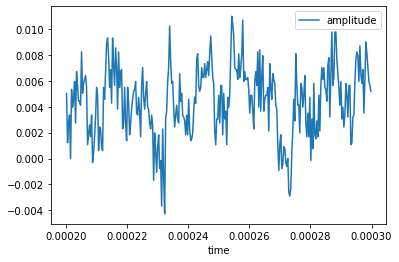

In [10]:
plot_signal(sample_signal)

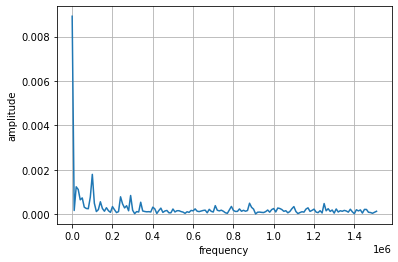

Fourier transform of the signal


In [11]:
showFFT(sample_signal, sample_N, sample_T)

The signal looks like a very exploitable sinusoidal, with clear cut frequencies. The noise does not seem excessive. All this is very encouraging, because even if we do not work directly on feeding the fourier transform to the neural nets, it still intuitively means that there are interesting features that we can extract from this.

In [12]:
#remove the last points so that the array length is divisible by the number of points per sample 
#in order to have equal lengths sample
def clean_data(df):
    """Cleans the data to remove the silence and make sure that the array is divisible by the number of points per sample

    Args:
        df (dataFrame): dataframe containing the signal amplitudes

    Returns:
        dataFrame: dataframe containing the signal but without the silence zones from the laser stopping before the microphones at the end of the experiment
    """
    epsilon =  1e-1
    #remove the silence at the end: 
    for i in range(len(df) - 1, 0, -1):
        if(df[0][i] > epsilon):
            print("deleted", (len(df) - i) / clock, "seconds from the end because we assume it is silence from", len(df) / clock, "seconds")
            return df[:i]

def split_csv(filename, T):
    """ Splits the csv into 160ms splits and sampling them at 16kHz to feed into our neural networks as .wav files

    Args:
        filename (String): name of the file in the folders
        T (Double): period of the signal

    Returns:
        dataFrames: split arrays of CSV stored in dataframes
    """
    df = pd.read_csv(data_folder + filename + '.csv', header = None)
    df = clean_data(df)
    df.rename(columns = {0:'amplitude'}, inplace = True)
    point_per_sample = int(160e-3 * clock)
    
    nb_of_samples = int(len(df)/point_per_sample)
    data = df[:nb_of_samples * point_per_sample]
    return np.array_split(data, nb_of_samples)






In [13]:
data_deformed = split_csv(deformed01, g_T)
data_rx = split_csv(rx01, g_T)

deleted 1.3556525359999991 seconds from the end because we assume it is silence from 10.495999999999993 seconds
deleted 1.2826049679999991 seconds from the end because we assume it is silence from 10.495999999999993 seconds


In [14]:
from scipy.io.wavfile import write
if False:
    #Transforming the data into a .wav file

    samplerate = 16000#int(clock) sample à 16khz
    file = "sample_A_DEFORMED1_C0"
    #convert the data into a 16 bit integer amplitude signal => change scale
    max_amplitude = np.max(np.abs(conduction['amplitude']))
    max_int16 = np.iinfo(np.int16).max
    #data = (conduction['amplitude'] * (max_int16/max_amplitude)).astype(np.int16)
    for index in range(len(samples)):
        sample = (samples[index] * (max_int16/max_amplitude)).astype(np.int16)
        write(file + str(index) + '.wav', samplerate, sample)





In [15]:
#reading the data and listening to it because why not, change this to True to listen!
#it's cool to listen to something you're just seeing as numbers!

if False:
    sd.play(conduction, 1e5)
    status = sd.wait()


### Idea 1 : using an SVM to separate the data
Do PCA on the data \
Apply SVM on the data \

### Idea 2 : using a neural network to separate the data
WPT (Wavelet package transform) \
Design a CNN (Convolutional Neural Network) \



In [16]:
16*1e3 / (3*1e6)

0.005333333333333333

In [17]:
1/0.005333333333333333

187.5

### Using transfer learning on a pre-trained sound classifier : Yamnet

The idea comes from this transfer learning tutorial on tensorflow : https://www.tensorflow.org/tutorials/audio/transfer_learning_audio

YAMNet is a pre-trained deep neural network that can predict over 500 classes of different audio events. In the context of this project, we will use the model as a high-level feature extractor. We try to use a concept called transfer learning to convert Yamnet to solve our own problem. The idea is the following : we keep the neural net layers that take the input files and transform them into features. This part has been trained on millions of audio signals and the hope is that the extracted features of Yamnet are also the same that are needed for classification. We then design our own neural net that takes these extracted features as input and performs a classification decision.

In [18]:
#load the yamnet model
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [19]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Function to ensure that the input .wav file is sampled at the right sampling rate

  Args:
      original_sample_rate (Integer): original sample rate of the waveform
      waveform (.Wav file): .wav file of the signal
      desired_sample_rate (int, optional): Defaults to 16000.

  Returns:
      desired sample rate and the waveform in .wav format
  """
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

### Loading the class types

In [20]:
#loading my own classes: 
my_classes = ['deformed', 'rx']
map_class_to_id = {'deformed':0, 'rx':1}

In [21]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

#class names of the original classifier layer of yamnet
class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)
print(class_names)

['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling', 'Speech synthesizer', 'Shout', 'Bellow', 'Whoop', 'Yell', 'Children shouting', 'Screaming', 'Whispering', 'Laughter', 'Baby laughter', 'Giggle', 'Snicker', 'Belly laugh', 'Chuckle, chortle', 'Crying, sobbing', 'Baby cry, infant cry', 'Whimper', 'Wail, moan', 'Sigh', 'Singing', 'Choir', 'Yodeling', 'Chant', 'Mantra', 'Child singing', 'Synthetic singing', 'Rapping', 'Humming', 'Groan', 'Grunt', 'Whistling', 'Breathing', 'Wheeze', 'Snoring', 'Gasp', 'Pant', 'Snort', 'Cough', 'Throat clearing', 'Sneeze', 'Sniff', 'Run', 'Shuffle', 'Walk, footsteps', 'Chewing, mastication', 'Biting', 'Gargling', 'Stomach rumble', 'Burping, eructation', 'Hiccup', 'Fart', 'Hands', 'Finger snapping', 'Clapping', 'Heart sounds, heartbeat', 'Heart murmur', 'Cheering', 'Applause', 'Chatter', 'Crowd', 'Hubbub, speech noise, speech babble', 'Children playing', 'Animal', 'Domestic animals, pets', 'Dog', 'Bark', 'Yip', 'Howl'

In [22]:
#load a .wav file
def load_wav_file(filename, info):
    """loads a wavefile and normalize the wav data for the model

    Args:
        filename (String): name of the file
        info (Boolean): show extra informations about the extracted .wav file

    Returns:
        [type]: [description]
    """
    sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')

    
    
    duration = len(wav_data)/sample_rate
    if info :
        print(f'Sample rate: {sample_rate} Hz')
        print(f'Total duration: {duration:.2f}s')
        print(f'Size of the input: {len(wav_data)}')



    #normalise the data
    waveform = wav_data / tf.int16.max
    return waveform

    
    
wav_file_name = wav_deformed_loc + str(1) + '_C0' + str(6) + '.wav'
wavefile = load_wav_file(wav_file_name, True)





Sample rate: 16000 Hz
Total duration: 30.49s
Size of the input: 487804


In [23]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [24]:
print("Audio of the laser")
Audio(wavefile, rate=16000)

Audio of the laser


In [25]:
scores, embeddings, spectrogram = model(wavefile)

In [26]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Mains hum


### some data visualisation 

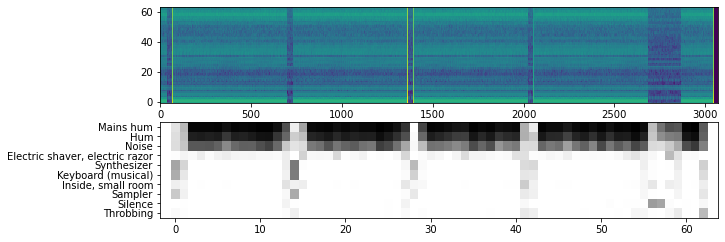

In [27]:
def view_sample_result(waveform):
    """Simple function to view  the yamnet interpretation of the signal and classification

    Args:
        waveform ([type]): [description]
    """
    plt.figure(figsize=(10, 6))

    # Plot the log-mel spectrogram (returned by the model).
    plt.subplot(3, 1, 2)
    plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

    # Plot and label the model output scores for the top-scoring classes.
    mean_scores = np.mean(scores, axis=0)
    top_n = 10
    top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
    plt.subplot(3, 1, 3)
    plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

    # patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
    # values from the model documentation
    patch_padding = (0.025 / 2) / 0.01
    plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
    # Label the top_N classes.
    yticks = range(0, top_n, 1)
    plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
    _ = plt.ylim(-0.5 + np.array([top_n, 0]))

view_sample_result(wavefile)

In [28]:
my_classes = ['deformed', 'rx']
map_class_to_id = {'deformed':0, 'rx':1}
DEFORMED_VAL = 0
RX_VAL = 1


In [29]:
#generate the data arrayed in this way : 
# embeddings, type
#fixed bug issues : 
#1) correct size of wavs
#2) transform in data series because the tensor slices had no idea of the organization (doc tensor series)
#this splitter uses one experiment for each of the validation sets
def get_files(experiment_number):
    """generates a dataset that can be used for training, validation or testing by agreggating .wavs from one experiment

    Args:
        experiment_number (Integer): the experiment to extract the data from

    Returns:
        [tf.Dataset]: A tensorflow dataset ready to be plugged into a model
    """
    filenames = []
    targets = []
    #get the recrystallized (initially deformed)  data:
    for i in range(deformed_number):
        filename = wav_deformed_loc + str(experiment_number) + '_C0' + str(i) + '.wav'
        targets.append(DEFORMED_VAL)
        filenames.append(filename)

    #get the non recrystallized (because it was already recrytallized) data:
    for i in range(rx_number):
        filename = wav_rx_loc + str(experiment_number) + '_C0' + str(i) + '.wav'
        targets.append(RX_VAL)
        filenames.append(filename)
    
    filenames = pd.Series(filenames, name='filenames')
    targets = pd.Series(targets, name='targets')
    print(filenames, targets)
    return tf.data.Dataset.from_tensor_slices((filenames, targets))



In [30]:
#this function was coded very quickly as an afterthought to test another way of distributing the data for training.
#It is improper and badly coded and should not be used as is into any serious implementation..

#fixing a seed for repeatability
seed = random.seed(42069)
def full_random_cross_validation_generation():
    train_target = []
    test_target = []
    val_target = []
    
    train_filename = []
    test_filename = []
    val_filename = []
    
    experiments_number = 3
    for i in range(deformed_number):
        for j in range(1, experiments_number + 1):
            filename = wav_deformed_loc + str(j) + '_C0' + str(i) + '.wav'
            choose = random.randint(0,2)
            if(choose == 0):
                train_filename.append(filename)
                train_target.append(DEFORMED_VAL)
            elif(choose == 1):
                test_filename.append(filename)
                test_target.append(DEFORMED_VAL)
            else:
                val_filename.append(filename)
                val_target.append(DEFORMED_VAL)
                
    for i in range(rx_number):
        for j in range(1, experiments_number + 1):
            filename = wav_rx_loc + str(j) + '_C0' + str(i) + '.wav'
            choose = random.randint(0,2)
            if(choose == 0):
                train_filename.append(filename)
                train_target.append(RX_VAL)
            elif(choose == 1):
                test_filename.append(filename)
                test_target.append(RX_VAL)
            else:
                val_filename.append(filename)
                val_target.append(RX_VAL)
        
        
    train_filename = pd.Series(train_filename, name='filenames')
    train_target = pd.Series(train_target, name='targets')            
    val_filename = pd.Series(val_filename, name='filenames')
    val_target = pd.Series(val_target, name='targets')
    test_filename = pd.Series(test_filename, name='filenames')
    test_target = pd.Series(test_target, name='targets')
   
    train = tf.data.Dataset.from_tensor_slices((train_filename, train_target))
    val = tf.data.Dataset.from_tensor_slices((val_filename, val_target)) 
    test = tf.data.Dataset.from_tensor_slices((test_filename, test_target)) 
    return train, val, test
        
    
    
                
    
    
    

In [31]:
#generating the dataset
file_train_set = get_files(1)
file_validation_set = get_files(2)
file_test_set = get_files(3)

0      ./all_samples/sample_A_DEFORMED1_C00.wav
1      ./all_samples/sample_A_DEFORMED1_C01.wav
2      ./all_samples/sample_A_DEFORMED1_C02.wav
3      ./all_samples/sample_A_DEFORMED1_C03.wav
4      ./all_samples/sample_A_DEFORMED1_C04.wav
                         ...                   
107         ./all_samples/sample_A_RX1_C051.wav
108         ./all_samples/sample_A_RX1_C052.wav
109         ./all_samples/sample_A_RX1_C053.wav
110         ./all_samples/sample_A_RX1_C054.wav
111         ./all_samples/sample_A_RX1_C055.wav
Name: filenames, Length: 112, dtype: object 0      0
1      0
2      0
3      0
4      0
      ..
107    1
108    1
109    1
110    1
111    1
Name: targets, Length: 112, dtype: int64
0      ./all_samples/sample_A_DEFORMED2_C00.wav
1      ./all_samples/sample_A_DEFORMED2_C01.wav
2      ./all_samples/sample_A_DEFORMED2_C02.wav
3      ./all_samples/sample_A_DEFORMED2_C03.wav
4      ./all_samples/sample_A_DEFORMED2_C04.wav
                         ...                   


In [32]:
#file_train_set, file_validation_set, file_test_set = full_random_cross_validation_generation()


In [33]:
print(file_train_set)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>


In [34]:
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

train_set = file_train_set.map(load_wav_for_map)
validation_set = file_validation_set.map(load_wav_for_map)
test_set = file_test_set.map(load_wav_for_map)

In [35]:
train_set.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [36]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))

# extract embedding
embedding_train_ds = train_set.map(extract_embedding).unbatch()
embedding_validation_ds = validation_set.map(extract_embedding).unbatch()
embedding_test_ds = test_set.map(extract_embedding).unbatch()

In [37]:
embedding_train_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [38]:
cached_train_ds = embedding_train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
cached_val_ds = embedding_validation_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
cached_test_ds = embedding_test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
#define a basic sequential model to train our data
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [40]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=50,
                                            restore_best_weights=True)

In [41]:
history = my_model.fit(cached_train_ds,
                       epochs=70,
                       validation_data=cached_val_ds,
                       callbacks=callback)

Epoch 1/70
221/221 [==============================] - 53s 219ms/step - loss: 0.2311 - accuracy: 0.9331 - val_loss: 1.9720 - val_accuracy: 0.4585
Epoch 2/70
221/221 [==============================] - 1s 2ms/step - loss: 0.2132 - accuracy: 0.9270 - val_loss: 2.2469 - val_accuracy: 0.4949
Epoch 3/70
221/221 [==============================] - 1s 2ms/step - loss: 0.2340 - accuracy: 0.9188 - val_loss: 2.2649 - val_accuracy: 0.4994
Epoch 4/70
221/221 [==============================] - 1s 2ms/step - loss: 0.2214 - accuracy: 0.9246 - val_loss: 2.1250 - val_accuracy: 0.4990
Epoch 5/70
221/221 [==============================] - 1s 2ms/step - loss: 0.1785 - accuracy: 0.9366 - val_loss: 2.3321 - val_accuracy: 0.4545
Epoch 6/70
221/221 [==============================] - 1s 2ms/step - loss: 0.1579 - accuracy: 0.9416 - val_loss: 2.2618 - val_accuracy: 0.4483
Epoch 7/70
221/221 [==============================] - 1s 2ms/step - loss: 0.1628 - accuracy: 0.9463 - val_loss: 2.5156 - val_accuracy: 0.4639
Epo

221/221 [==============================] - 1s 2ms/step - loss: 0.0550 - accuracy: 0.9792 - val_loss: 4.2623 - val_accuracy: 0.4721
Epoch 59/70
221/221 [==============================] - 1s 2ms/step - loss: 0.0489 - accuracy: 0.9813 - val_loss: 4.2840 - val_accuracy: 0.4840
Epoch 60/70
221/221 [==============================] - 1s 2ms/step - loss: 0.0528 - accuracy: 0.9829 - val_loss: 4.1527 - val_accuracy: 0.4872
Epoch 61/70
221/221 [==============================] - 1s 2ms/step - loss: 0.0523 - accuracy: 0.9785 - val_loss: 4.1317 - val_accuracy: 0.4872
Epoch 62/70
221/221 [==============================] - 1s 2ms/step - loss: 0.0540 - accuracy: 0.9800 - val_loss: 3.9998 - val_accuracy: 0.4882
Epoch 63/70
221/221 [==============================] - 1s 2ms/step - loss: 0.0513 - accuracy: 0.9817 - val_loss: 4.0688 - val_accuracy: 0.4875
Epoch 64/70
221/221 [==============================] - 1s 3ms/step - loss: 0.0523 - accuracy: 0.9797 - val_loss: 3.9338 - val_accuracy: 0.4857
Epoch 65/70

Accuracy on the training set keeps going up, but there is no change to the validation accuracy. What's going on??
This seems to indicate that our model is not working at all : we at least expected the validation accuracy to go over 50%. The model isn't even doing better than random guesses.
Let's try to find out before increasing the duration of the training.

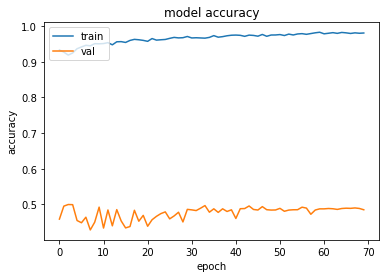

In [42]:
#plotting the history of training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
classifications = my_model.evaluate(cached_val_ds)
classifications = my_model.evaluate(cached_test_ds)

221/221 [==============================] - 26s 116ms/step - loss: 4.0672 - accuracy: 0.4780


In [44]:
print(classifications)

[4.067170143127441, 0.4780328869819641]


In [45]:
#why is the neural network getting 0.5 percent accuracy on a perfectly balanced dataset : That means it's guessing only one or the other
print(type(my_model))

<class 'keras.engine.sequential.Sequential'>


./all_samples/sample_A_DEFORMED1_C05.wav
tf.Tensor(
[[0.         0.         0.02457066 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]], shape=(63, 1024), dtype=float32)
[0.07679664 0.38682288]
The main sound is: rx

./all_samples/sample_A_RX1_C023.wav
tf.Tensor(
[[0.         0.         0.02457066 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.  

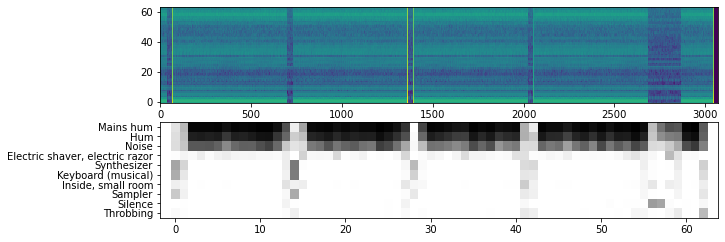

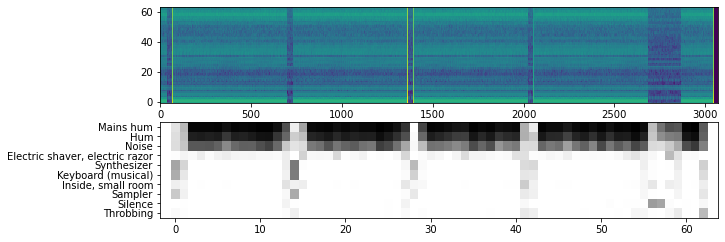

In [46]:
switch = True
for i in range(2):
    if switch :
        f = wav_deformed_loc
    else :
        f = wav_rx_loc
    filename = f + str(1) + '_C0' + str(i * 18 + 5) + '.wav'
        
    print(filename)
    data = load_wav_file(filename, False)
    Audio(data, rate=16000)
    scores, embeddings, spectrogram = model(data)
    print(embeddings)
    view_sample_result(data)
    prediction = my_model(embeddings).numpy()
    pred = prediction.mean(axis=0)
    print(pred)
    inferred_class = my_classes[prediction.mean(axis=0).argmax()]
    print(f'The main sound is: {inferred_class}')
    print()
    switch = False


### Yamnet does not work properly, and here is why
As we can see from these extracted embeddings, scores and logs of separate audio samples in two different experiments (the middle .wav of an initially deformed steel layer VS a pre-recrystallized layer. Yamnet produces the same embeddings and classification. This model is clearly not fine tuned for our problem and thus is unable to see the difference between the two. It's still quite impressive that even though they are for us two different signals extracted from two pieces of audio, yamnet "sees" absolutely close to no difference between the two.

So even thought using yamnet as our feature extractor seemed like a good solution at first, it is actually unable to work on our dataset. Our subsequent layer has no chance of differentiating between the two states which is why it's stuck at around 50% accuracy. Hence, instead of counting on an already trained model we will try to train fully our own neural net on all the layers.